# Card recognition

Current score:  
Color :110/110  
Symbol: 106/110  
Character: 109/110  
Total: 105 /110  

#### For further improvement
Use a contour based metric to improve symbol recognition
Could use the distance map instead of the center of gravity, because if some part is not detected => shift the center of gravity => shift the entire mask => big loss
Take both corner of the image into account, classify both keep the best one into account 

In [1]:
import cv2
from PIL import Image
import numpy as np
import os
import pickle

from recognition_functions import *

PATH_CARD_CLASSIFIER_MASKS = "data/card_classifier_masks/"
PATH_SINGLE_CARDS_GROUND_TRUTH = "data/single_cards_gt/"

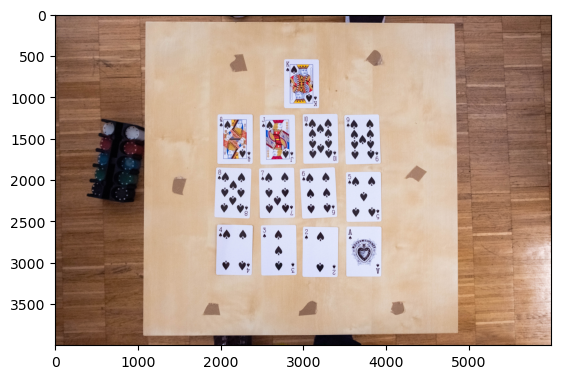

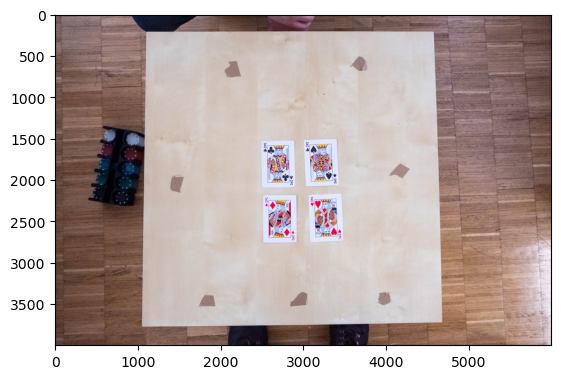

In [2]:
path_data = "data/train"
path_setup = "data/image_setup/"

spade_file = os.path.join(path_setup, f"spades_suits.jpg")
kings_file = os.path.join(path_setup, f"kings.jpg")

# open the image
im_spades = Image.open(spade_file)
plt.imshow(im_spades)
plt.show()

im_kings = Image.open(kings_file)
plt.imshow(im_kings)
plt.show()

## Color & symbol

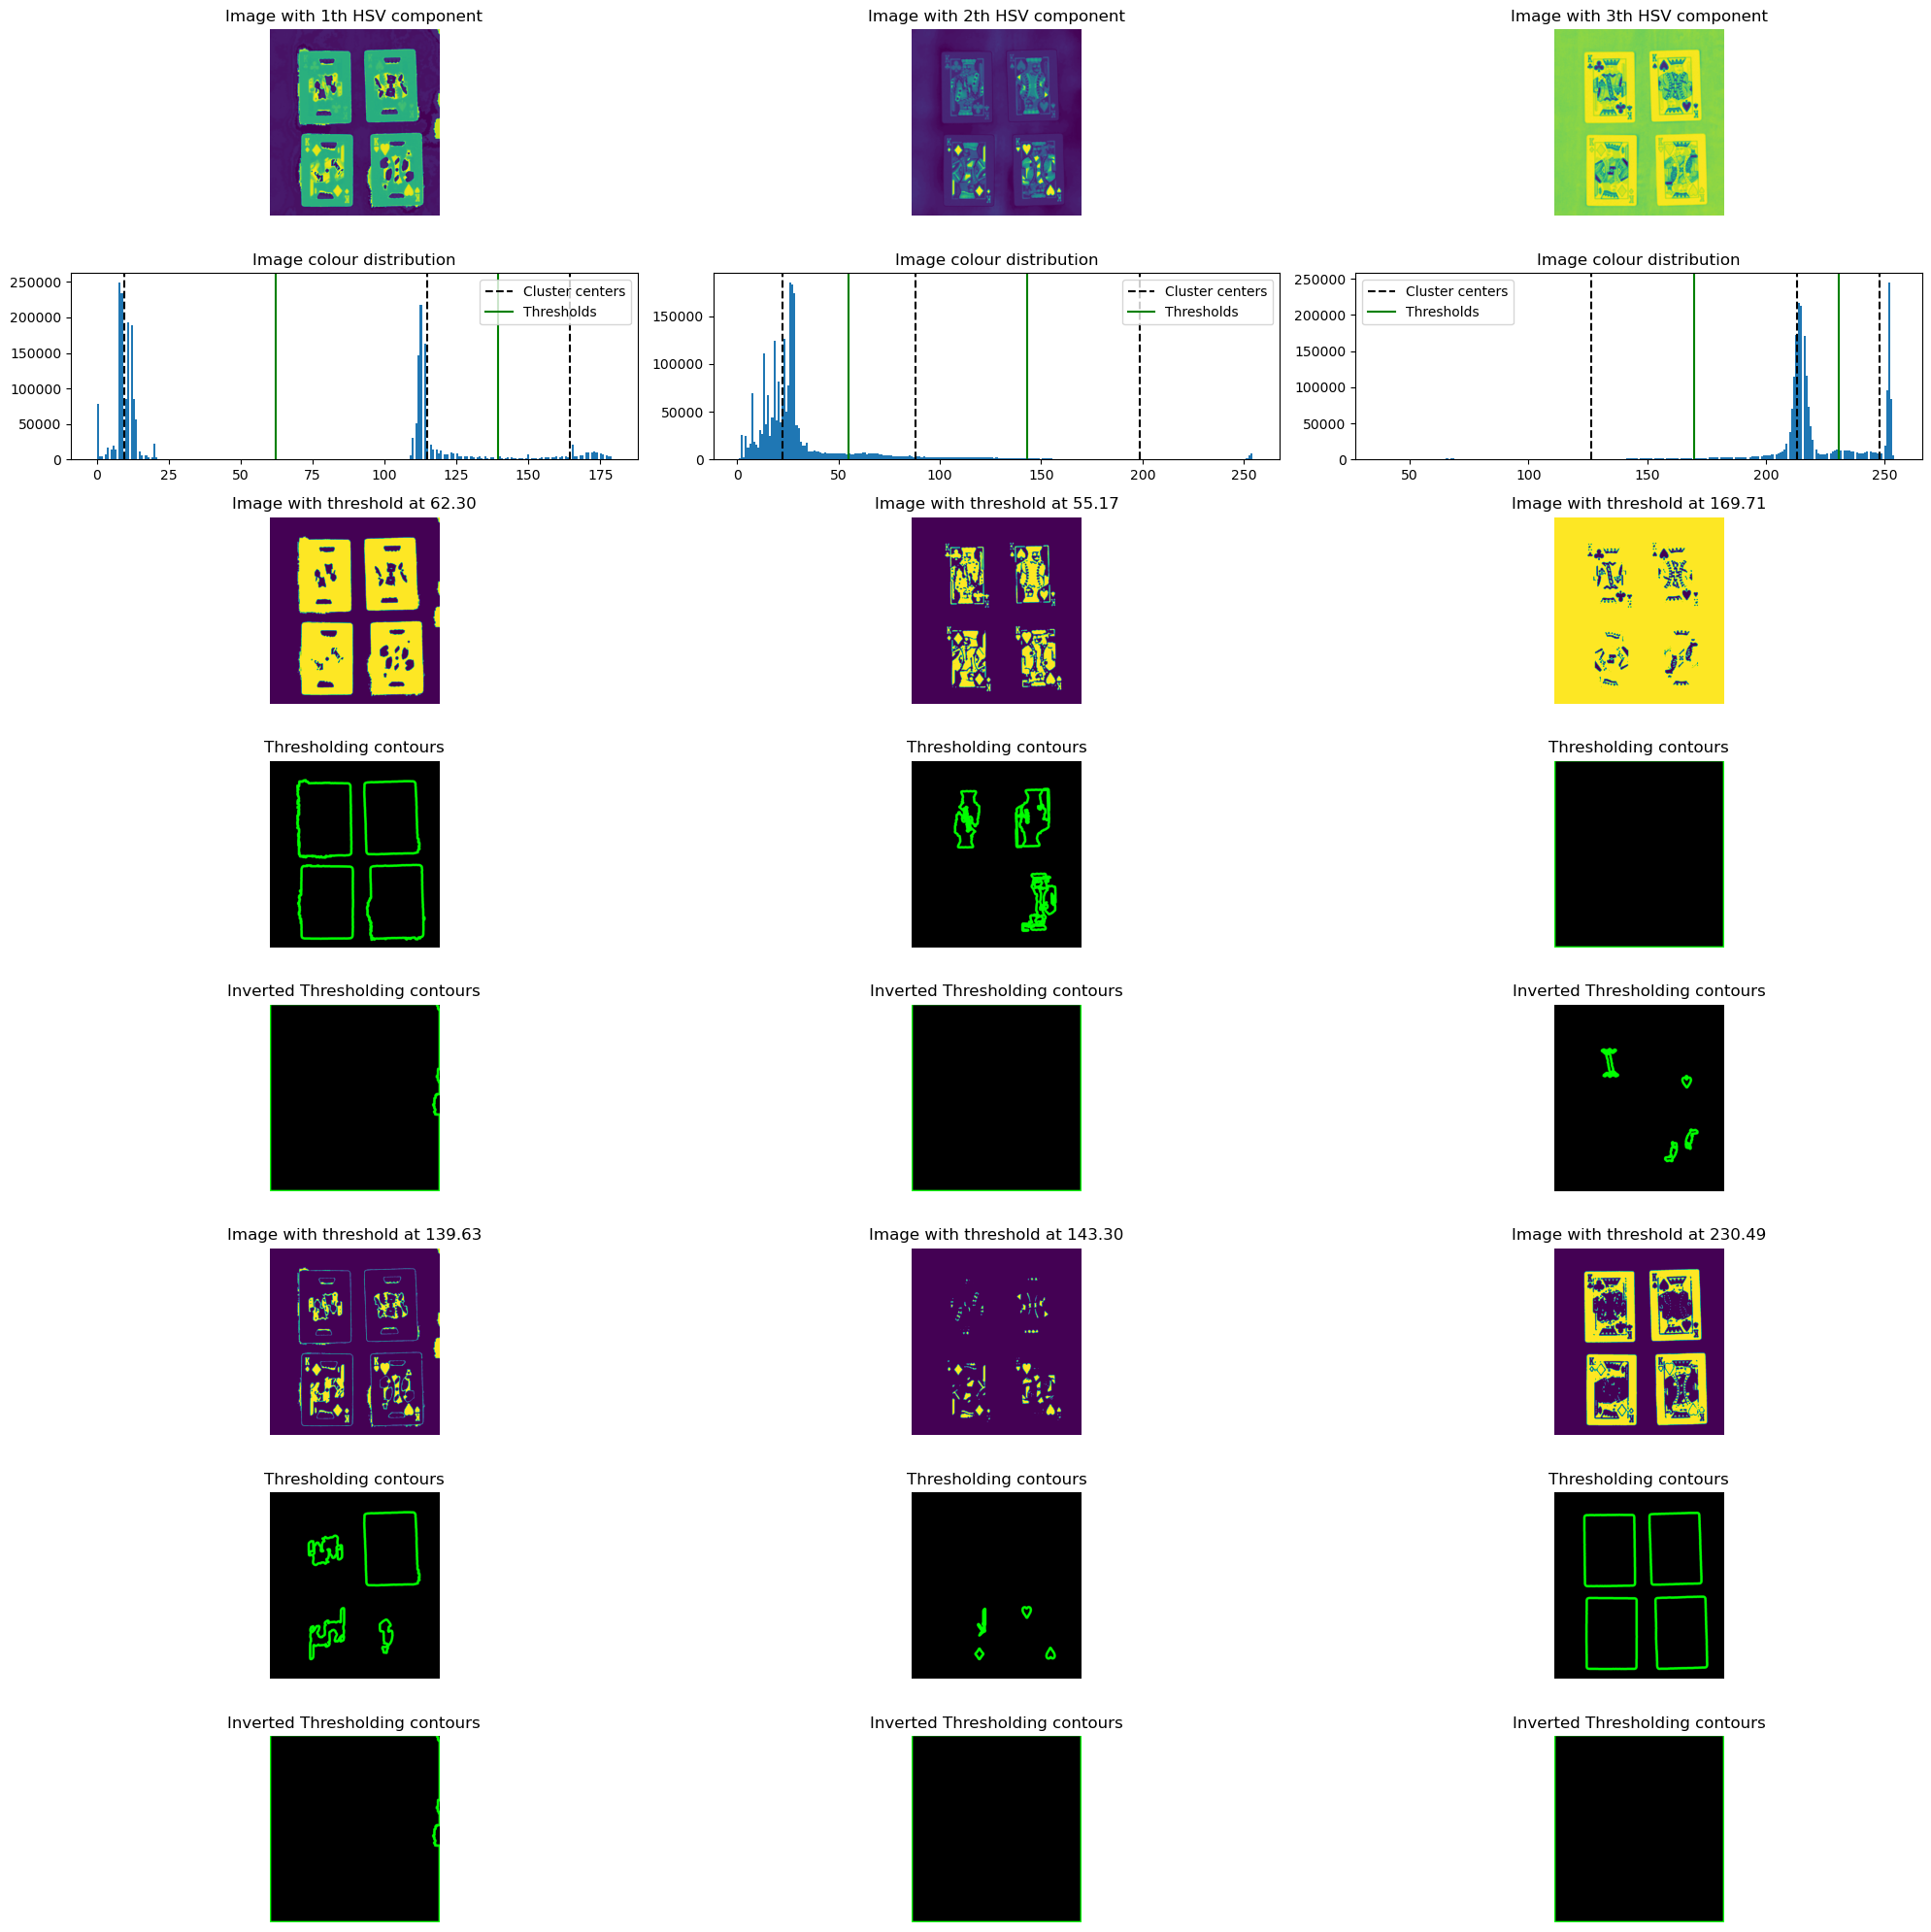

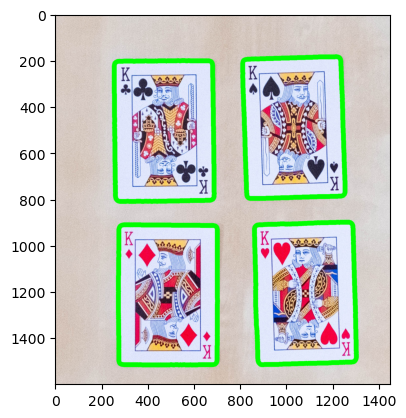

In [4]:
# Extract contour of kings
table_kings = table_extraction(np.array(im_kings))
selected_kings = table_kings[1250:2850, 1250:2700]
kings_contours = extract_candidate_contours(selected_kings, 4, plot = True)[10]
img = cv2.drawContours(selected_kings.copy(), kings_contours, -1,(0,255,0),20)
plt.imshow(img)
plt.show()

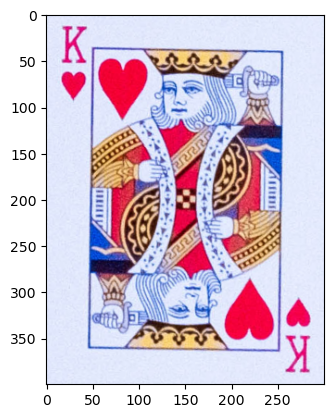

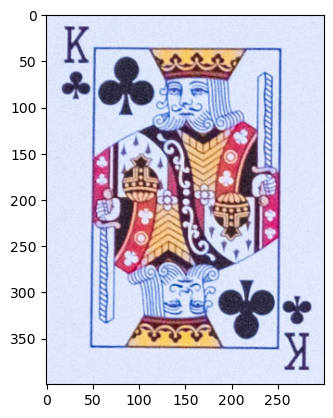

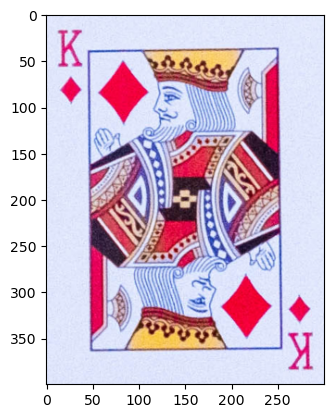

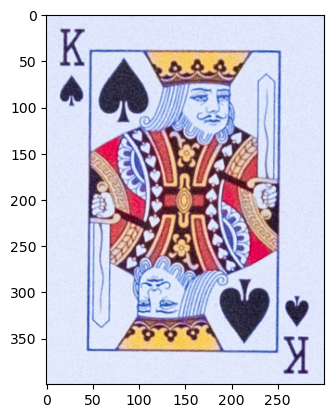

In [5]:
def extract_cards_from_contours(img, contours):
    card_size = [300,400]

    contour_corners = []
    for card_contour in contours:
        peri = cv2.arcLength(card_contour,True)
        approx = cv2.approxPolyDP(card_contour,0.02*peri,True)
        corners = np.array(approx[:,0,:],np.float32) #Just remove useless middle dimension

        corners = reorder_corners(corners)
        contour_corners.append(corners)

    extracted_cards = []
    for corners in contour_corners:

        h = np.array([[0,0],[card_size[0],0],[card_size[0],card_size[1]],[0,card_size[1]] ],np.float32)

        transform = cv2.getPerspectiveTransform(corners, h)
        card = cv2.warpPerspective(img,transform,card_size)
        extracted_cards.append(card)

    for i,card in enumerate(extracted_cards):
        plt.imshow(card)
        plt.show()
    return extracted_cards

# Extract king cards
extracted_cards = extract_cards_from_contours(selected_kings, kings_contours)

In [6]:
def extract_symbol_feature(card, card_name="Default_name", plot=False):
    """
    Extract features about symbol/color from an image of a card
    Extracted feature:
         Cropped image of the symbol
         Detected color ('r'-red or 'b'-black)
         A mask of the symbol centered at (25,25)
    Assume:
        The symbol is always at the same place defined by the constant below
        The symbol is the second largest component after the background at that location
        The symbol fits in 50x50
        
    """
    TOP_SYMBOL = 0.13
    BOTTOM_SYMBOL = 0.26
    LEFT_SYMBOL = 0.016
    RIGHT_SYMBOL = 0.17
    
    # Focus on symbol
    h, w, _ = card.shape
    cropped = card[int(TOP_SYMBOL * h):int(BOTTOM_SYMBOL * h), int(LEFT_SYMBOL *  w): int(RIGHT_SYMBOL * w)]
    
    gray = cv2.cvtColor(cropped,cv2.COLOR_BGR2GRAY)
    flag, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)
    
    # Extract connected components
    connectivity = 4
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(~thresh, connectivity)
    
    # Find label with the second biggest area (after background)
    symbol_label = np.argsort(stats[:,4])[::-1][1]
    
    # Create a centered mask around (25,25) of the symbol
    center_y, center_x = centroids[symbol_label]
    x, y = (labels == symbol_label).nonzero()
    centered_x = x - int(center_x) + 25
    centered_y = y - int(center_y) + 25
    centered_mask = np.zeros((50, 50), dtype=bool)
    centered_mask[(centered_x, centered_y)] = True
    
    # Mean color in symbol
    mean_color =  cropped[np.where(labels == symbol_label)].mean(axis=(0))
    
    # Determine closest color between red and black
    dist_R = np.abs([255, 0, 0] - mean_color).sum()
    dist_B = mean_color.sum()
    color = 'r' if dist_B > dist_R  else 'b'
    
    if(plot):
        print(f"Symbol extraction pipeline for {card_name}")
        fig, axes = plt.subplots(1, 5, figsize=(7, 30),tight_layout=True)
        axes[0].set_title(f"Cropped")
        axes[0].imshow(cropped)
        axes[1].set_title(f"Threshold")
        axes[1].imshow(thresh)
        axes[2].set_title(f"CC")
        axes[2].imshow(labels)
        
        symbol_img = cropped.copy()
        symbol_img[np.where(labels != symbol_label)] = [255, 255, 255]
        axes[3].set_title(f"Extracted symbol")
        axes[3].imshow(symbol_img)
        axes[4].set_title(f"Centered mask")
        axes[4].imshow(centered_mask)

        plt.show()
        
    
    return (cropped, color, centered_mask)

with open(PATH_CARD_CLASSIFIER_MASKS + 'name_to_mask.pickle', 'rb') as handle:
    name_to_mask = pickle.load(handle)
    for name, mask in name_to_mask.items():
        name_to_mask[name]= mask.astype(bool)
    
def symbol_classifier_with_mask(color, mask, name_to_mask = name_to_mask): 
    if color == "r":
        score_H = (name_to_mask["H"] & mask).sum() / (name_to_mask["H"] | mask).sum()
        score_D = (name_to_mask["D"] & mask).sum() / (name_to_mask["D"] | mask).sum()

        return 'H' if score_H > score_D else 'D'
    elif color == "b":
        score_C = (name_to_mask["C"] & mask).sum() / (name_to_mask["C"] | mask).sum()
        score_S = (name_to_mask["S"] & mask).sum() / (name_to_mask["S"] | mask).sum()
        return 'C' if score_C > score_S else 'S'

Symbol extraction pipeline for img_0


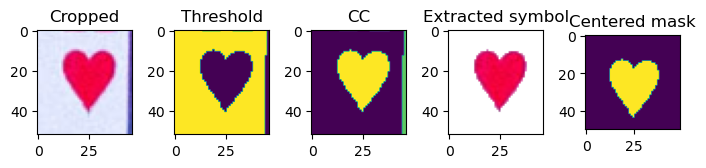

Symbol extraction pipeline for img_1


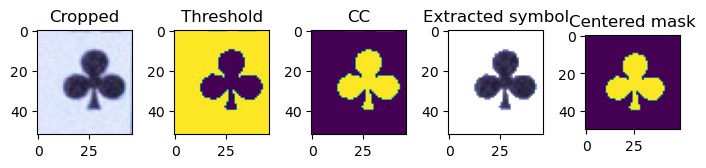

Symbol extraction pipeline for img_2


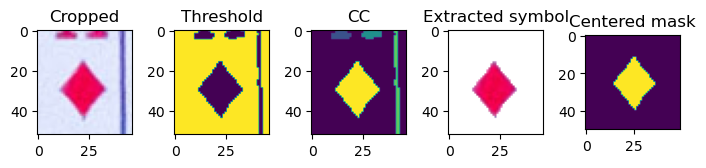

Symbol extraction pipeline for img_3


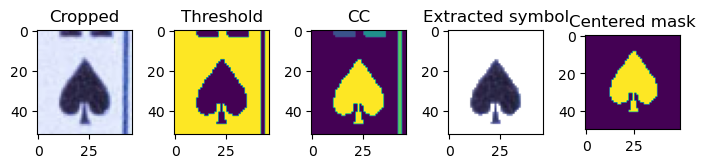

In [7]:
# Create dict for symbol comparaison
train_symbol_features = [extract_symbol_feature(card,f"img_{idx}" ,plot=True) for idx, card in enumerate(extracted_cards)]

masks = [mask for img, color, mask in train_symbol_features]
names = ["H", "C", "D", "S"]

name_to_mask = dict()
for name, mask in zip(names, masks):
    name_to_mask[name] = mask

#with open(PATH_CARD_CLASSIFIER_MASKS + 'name_to_mask.pickle', 'wb') as handle:
#    pickle.dump(name_to_mask, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [8]:
path_cards = "data/single_cards/"

test_cards = []
for i in range(110):
    file = os.path.join(path_cards, f"img_{str(i)}.jpeg")
    img = Image.open(file)
    test_cards.append(np.array(img))

In [9]:
#with open(PATH_SINGLE_CARDS_GROUND_TRUTH +"ground_single_cards_colors", "wb") as fp:   #Pickling
#    pickle.dump(ground_truth_colors, fp)

In [10]:
#with open(PATH_SINGLE_CARDS_GROUND_TRUTH + "ground_single_cards_symbols", "wb") as fp:   #Pickling
#    pickle.dump(groud_truth_symbols, fp)

In [11]:
with open(PATH_SINGLE_CARDS_GROUND_TRUTH + "ground_single_cards_colors", "rb") as fp:   # Unpickling
    ground_truth_color = pickle.load(fp)
    
with open(PATH_SINGLE_CARDS_GROUND_TRUTH + "ground_single_cards_symbols", "rb") as fp:   #Pickling
    ground_truth_symbol = pickle.load(fp)

def test_color(imgs, colors, ground_truth=ground_truth_color):
    error_idx = []
    for i in range(len(colors)):
        if(colors[i] != ground_truth[i]):
            error_idx.append(i)
       
    print(f"{len(error_idx)} bad color prediction(s)\n")
    for i in error_idx:
        print(f"Error for img {i}, {colors[i]} instead of {ground_truth[i]}")
        plt.imshow(imgs[i])        
        plt.show()
        
def test_symbols(imgs, symbols, ground_truth=ground_truth_symbol):
    error_idx = []
    for i in range(len(symbols)):
        if(symbols[i] != ground_truth[i]):
            error_idx.append(i)
       
    print(f"{len(error_idx)} bad symbols prediction(s)\n")
    for i in error_idx:
        print(f"Error for img {i}, {symbols[i]} instead of {ground_truth[i]}")
        plt.imshow(imgs[i])        
        plt.show()

In [12]:
symbol_features = [extract_symbol_feature(card,f"img_{idx}" ,plot=False) for idx, card in enumerate(test_cards)]

imgs = [img for img, color, mask  in symbol_features]

In [13]:
colors = [color for img, color, mask  in symbol_features]
test_color(imgs, colors)

0 bad color prediction(s)



4 bad symbols prediction(s)

Error for img 21, S instead of C


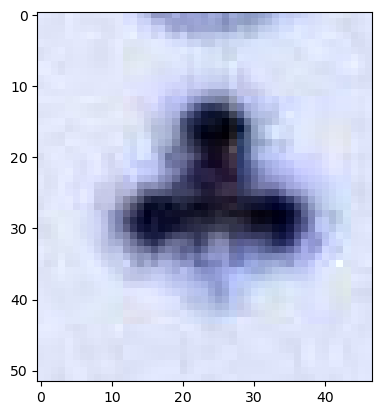

Error for img 24, S instead of C


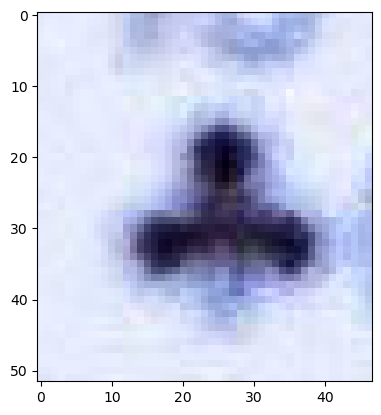

Error for img 25, D instead of H


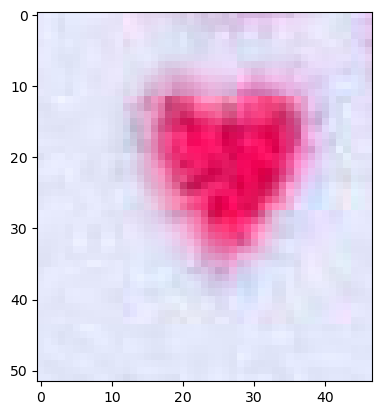

Error for img 29, S instead of C


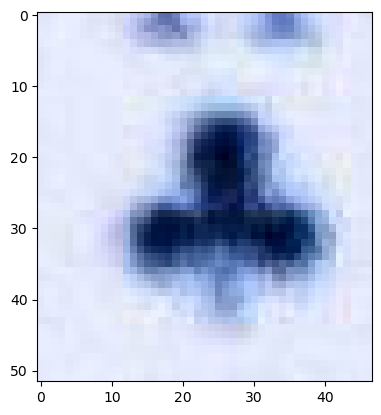

In [14]:
symbols = [symbol_classifier_with_mask(color, mask) for img, color, mask  in symbol_features]
test_symbols(imgs, symbols)

### Unused

In [15]:
def symbol_classifier(color, compactness):
    # RED
    HEART_COMPACTNESS = 0.2
    DIAMOND_COMPACTNESS = 0.25
    #BLACK
    CLUB_COMPACTNESS = 0.33
    SPADE_COMPACTNESS = 0.28 
    
    if color == "r":
        diff_H = abs(compactness - HEART_COMPACTNESS)
        diff_D = abs(compactness - DIAMOND_COMPACTNESS)
        return 'H' if diff_H < diff_D else 'D'
    elif color == "b":
        diff_C = abs(compactness - CLUB_COMPACTNESS)
        diff_S = abs(compactness - SPADE_COMPACTNESS)
        return 'C' if diff_C < diff_S else 'S'

## Card number

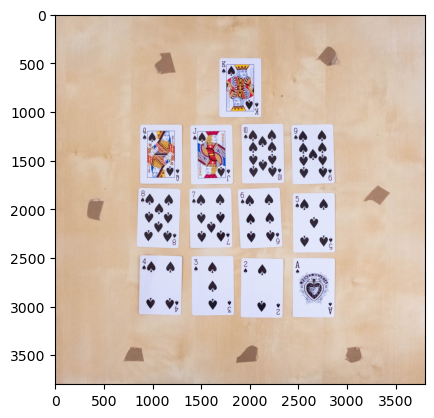

In [16]:
table_spades = table_extraction(np.array(im_spades))
plt.imshow(table_spades)
plt.show()

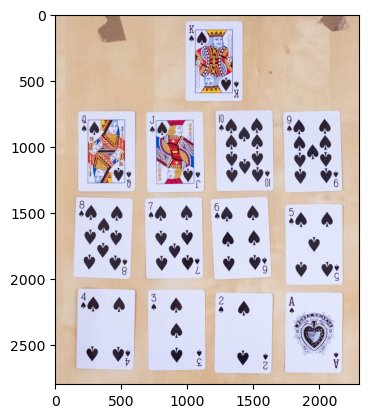

In [17]:
selected_spades = table_spades[400:3200, 700:3000]
plt.imshow(selected_spades)
plt.show()


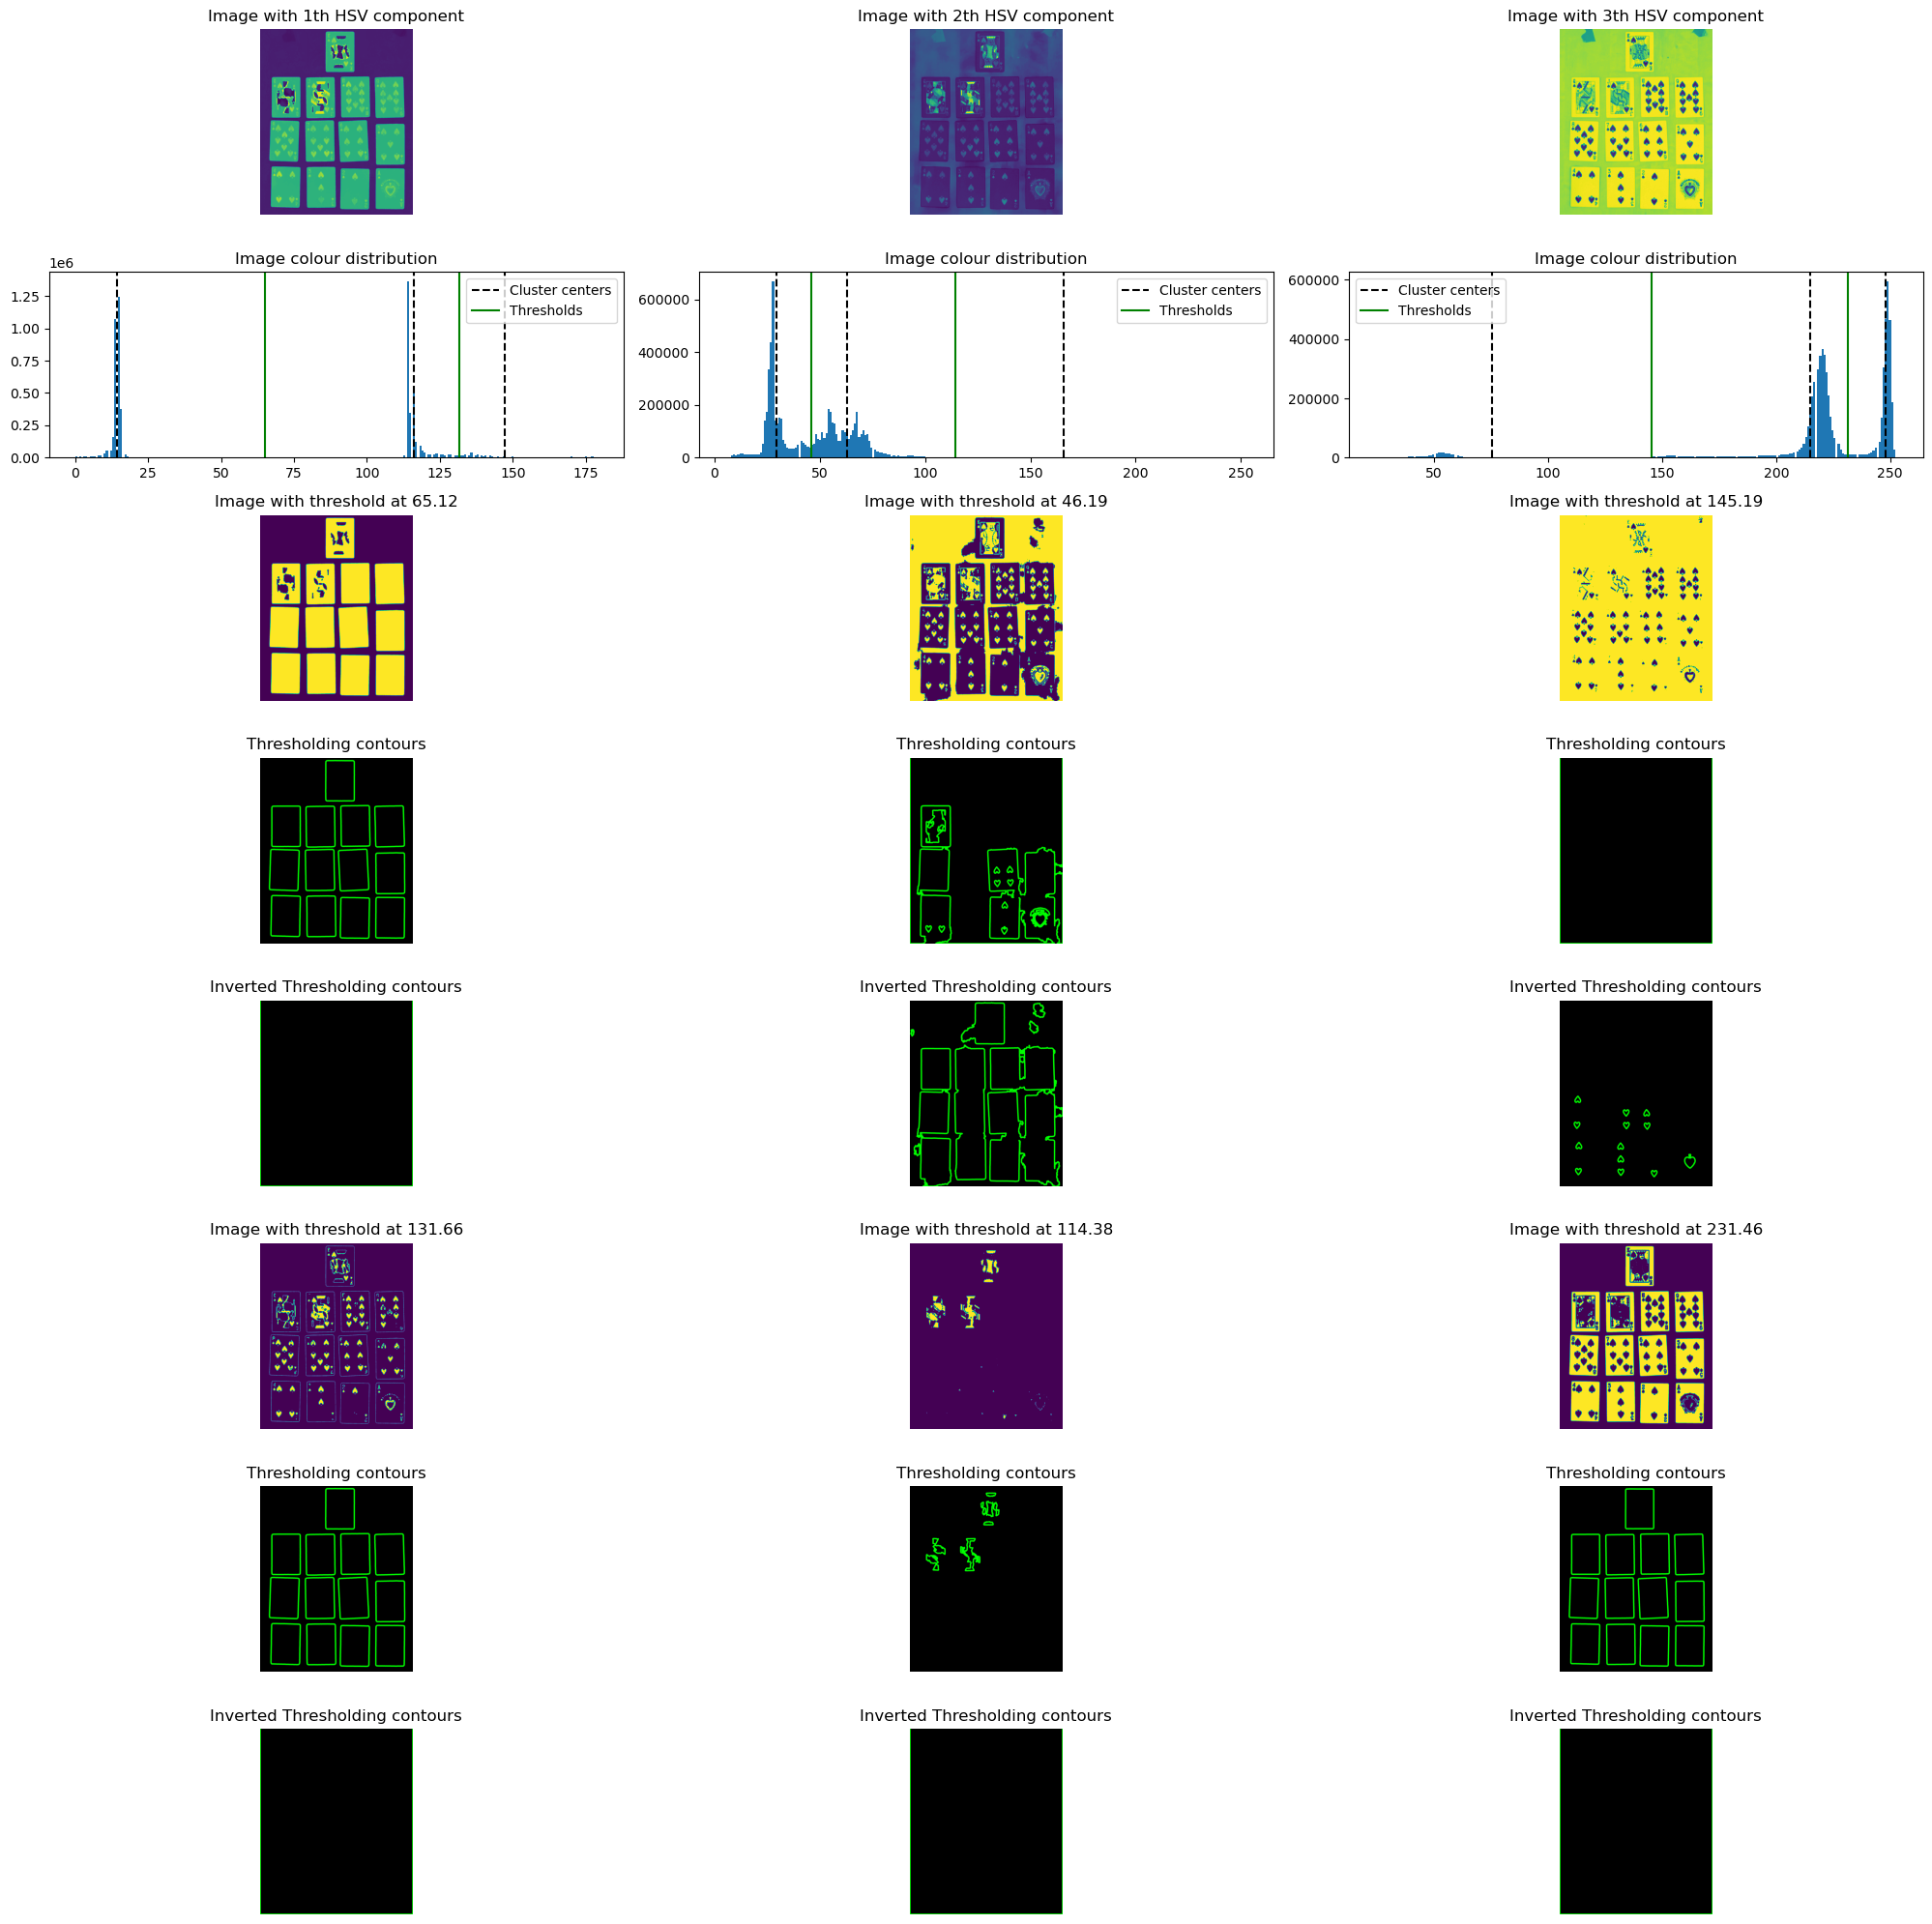

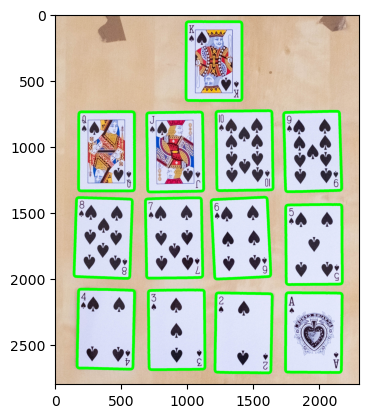

In [18]:
spades_contours = extract_candidate_contours(selected_spades, 13, plot = True)[10]
img = cv2.drawContours(selected_spades.copy(), spades_contours, -1,(0,255,0),20)
plt.imshow(img)
plt.show()

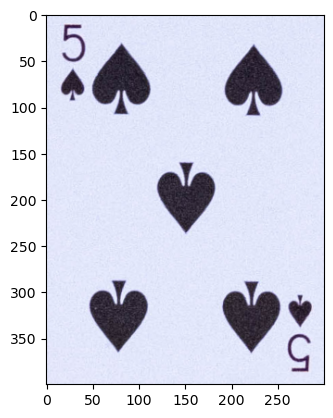

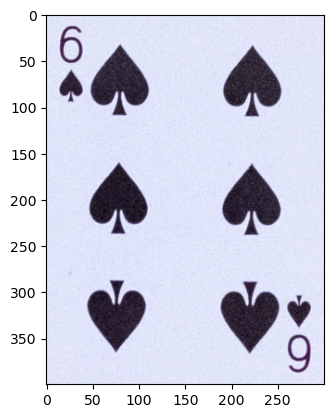

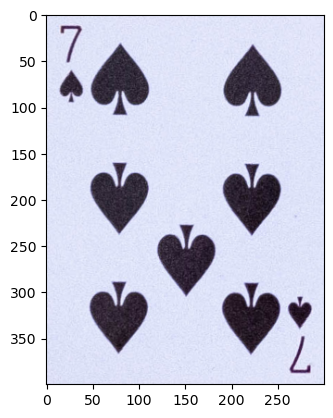

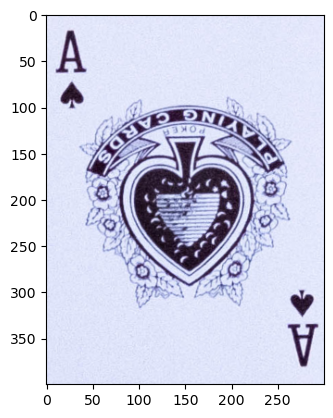

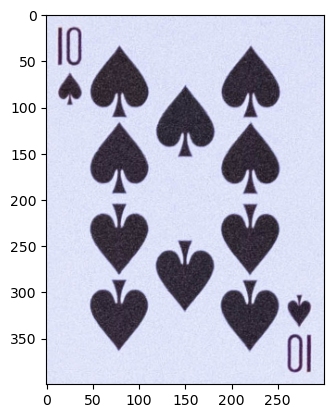

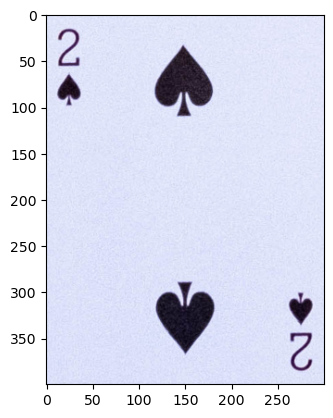

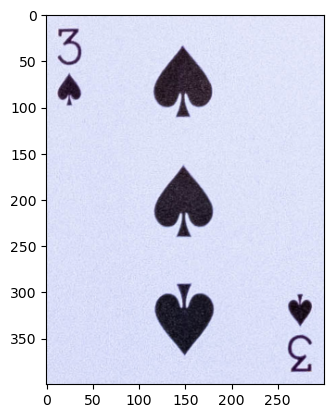

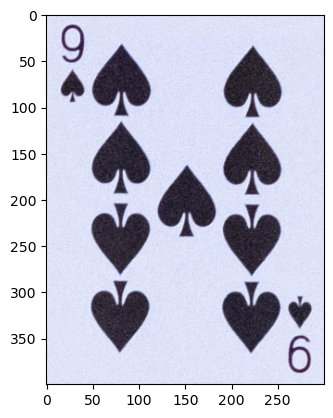

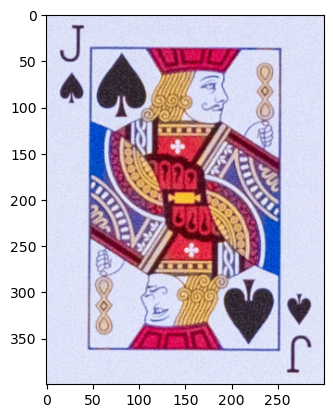

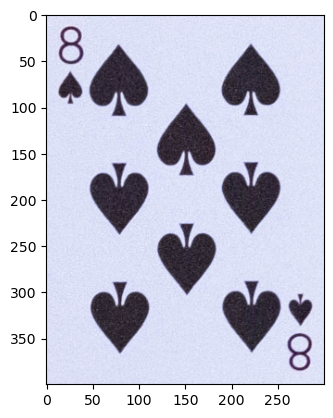

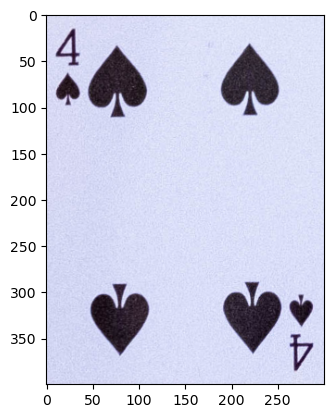

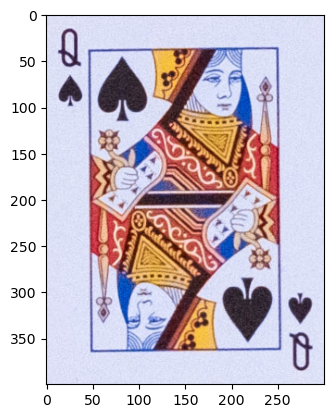

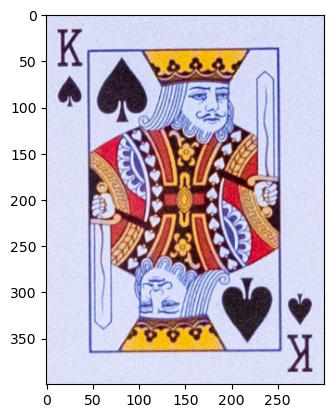

In [19]:
# Extract king cards
extracted_cards = extract_cards_from_contours(selected_spades, spades_contours)

In [20]:
card = extracted_cards[0]

In [21]:
def extract_card_character(card, card_name="Default_name", plot=False):
    TOP_CHAR = 0
    BOTTOM_CHAR = 0.16
    LEFT_CHAR = 0.016
    RIGHT_CHAR = 0.18

    # Focus on character
    h, w, _ = card.shape
    cropped = card[int(TOP_CHAR * h):int(BOTTOM_CHAR * h), int(LEFT_CHAR *  w): int(RIGHT_CHAR * w)]
    
    gray = cv2.cvtColor(cropped,cv2.COLOR_BGR2GRAY)
    flag, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)
    
    # Extract connected components
    connectivity = 4
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(~thresh, connectivity)
    
    # Find label with the second biggest area (after background)
    symbol_label = np.argsort(stats[:,4])[::-1][1]
    
    char_binary = labels == symbol_label
    
    h_cropped, w_cropped, _ = cropped.shape
    # Create a centered mask of the symbol
    center_y, center_x = centroids[symbol_label]
    x, y = (labels == symbol_label).nonzero()
    centered_x = x - int(center_x) + int(h_cropped / 2)
    centered_y = y - int(center_y) + int(w_cropped / 2)
    centered_mask = np.zeros((h_cropped, w_cropped), dtype=bool)
    centered_mask[(centered_x, centered_y)] = True
    
    if(plot):
        print(f"Character extraction pipeline for {card_name}")
        fig, axes = plt.subplots(1, 4, figsize=(7, 30),tight_layout=True)
        axes[0].set_title(f"Cropped")
        axes[0].imshow(cropped)
        axes[1].set_title(f"Threshold")
        axes[1].imshow(thresh)
        axes[2].set_title(f"CC")
        axes[2].imshow(labels)
        axes[3].set_title(f"Centered mask")
        axes[3].imshow(centered_mask)

        plt.show()
    
    return (cropped, centered_mask)

Character extraction pipeline for Default_name


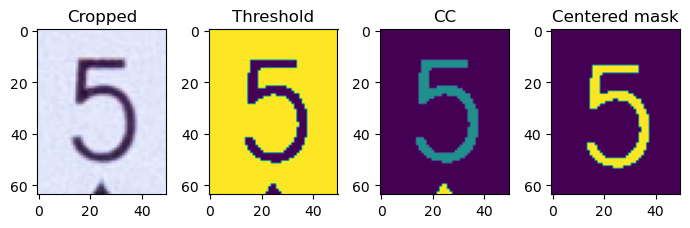

Character extraction pipeline for Default_name


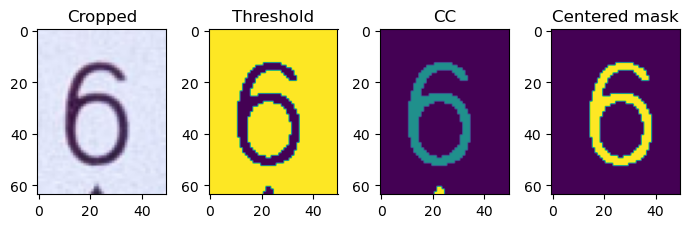

Character extraction pipeline for Default_name


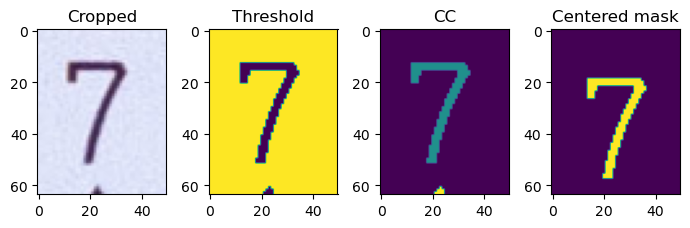

Character extraction pipeline for Default_name


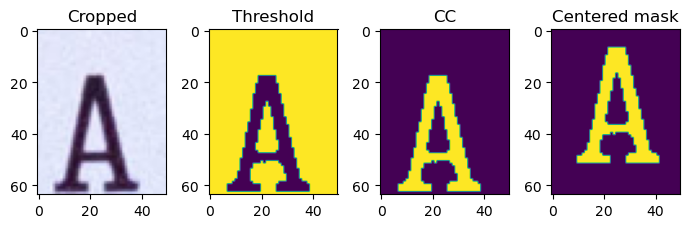

Character extraction pipeline for Default_name


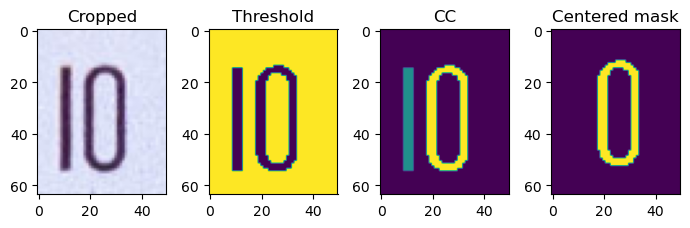

Character extraction pipeline for Default_name


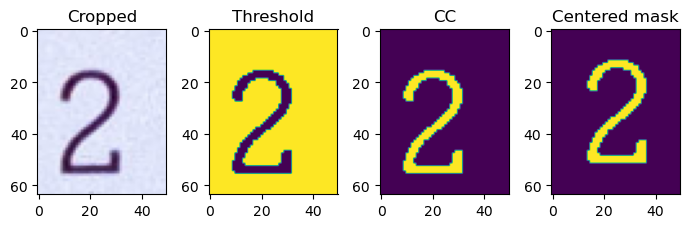

Character extraction pipeline for Default_name


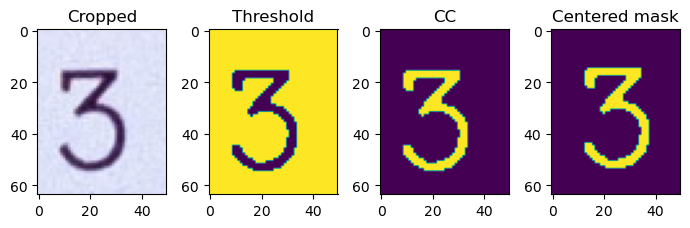

Character extraction pipeline for Default_name


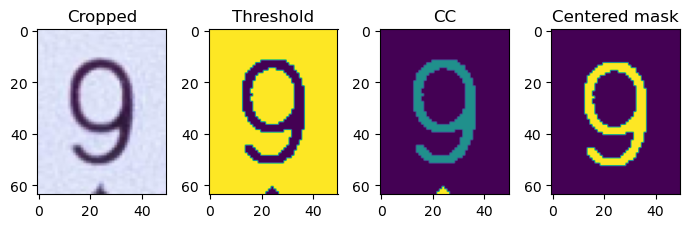

Character extraction pipeline for Default_name


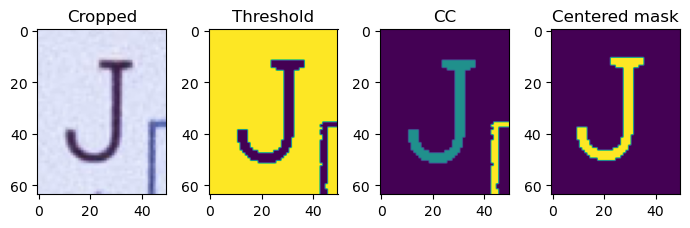

Character extraction pipeline for Default_name


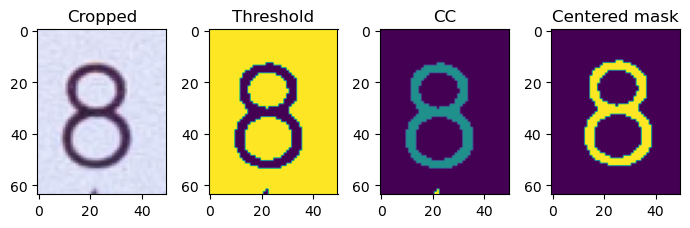

Character extraction pipeline for Default_name


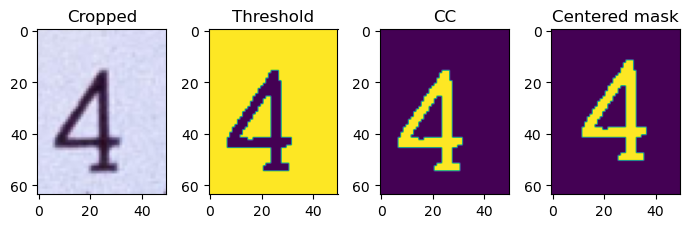

Character extraction pipeline for Default_name


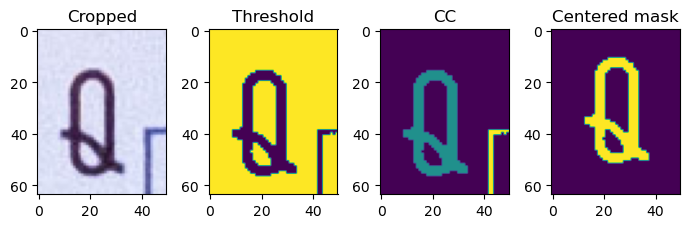

Character extraction pipeline for Default_name


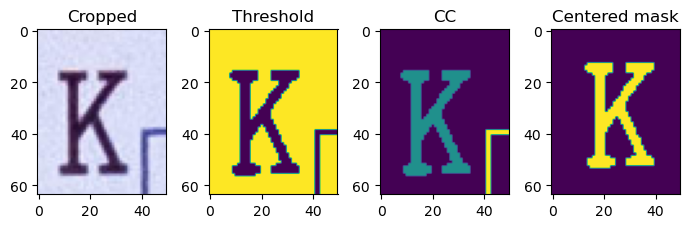

In [22]:
train_symbol_features = [extract_card_character(card, plot=True) for card in extracted_cards]

In [23]:
masks_labels = ["5", "6", "7", "A", "10", "2","3", "9","J","8","4", "Q", "K"]
char_masks = [mask for crop, mask in train_symbol_features]

char_to_mask = dict()
for name, mask in zip(masks_labels, char_masks):
    char_to_mask[name] = mask

#with open(PATH_CARD_CLASSIFIER_MASKS +'char_to_mask.pickle', 'wb') as handle:
#    pickle.dump(char_to_mask, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [24]:
with open(PATH_CARD_CLASSIFIER_MASKS + 'char_to_mask.pickle', 'rb') as handle:
    char_to_mask = pickle.load(handle)
    for name, mask in char_to_mask.items():
        char_to_mask[name]= mask.astype(bool)
    
def char_classifier_with_mask(mask, char_to_mask = char_to_mask): 
    best_score = -1
    best_label = None
    for label, label_mask in char_to_mask.items():
        score = (mask & label_mask).sum() / (mask | label_mask).sum()
        if (score > best_score):
            best_score = score
            best_label = label
    return best_label

In [25]:
char_features = [extract_card_character(card,f"img_{idx}" ,plot=False) for idx, card in enumerate(test_cards)]

In [26]:
#with open(PATH_SINGLE_CARDS_GROUND_TRUTH + "ground_single_cards_char", "wb") as fp:   #Pickling
#    pickle.dump(ground_truth_char, fp)

In [27]:
with open(PATH_SINGLE_CARDS_GROUND_TRUTH + "ground_single_cards_char", "rb") as fp:   #Pickling
    ground_truth_char = pickle.load(fp)

def test_char(imgs, chars, ground_truth=ground_truth_char):
    error_idx = []
    for i in range(len(chars)):
        if(chars[i] != ground_truth[i]):
            error_idx.append(i)
       
    print(f"{len(error_idx)} bad char prediction(s)\n")
    for i in error_idx:
        print(f"Error for img {i}, {chars[i]} instead of {ground_truth[i]}")
        plt.imshow(imgs[i])        
        plt.show()

1 bad char prediction(s)

Error for img 24, 8 instead of 10


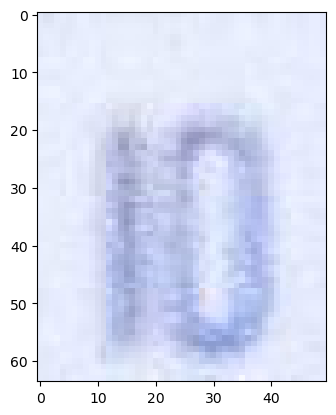

In [28]:
predicted_char = [char_classifier_with_mask(mask) for img, mask  in char_features]
imgs = [img for img, mask  in char_features]


test_char(imgs, predicted_char)

### Discussion
In char 10 only the 0 is taken into account since we are keeping only one principal component